# Quantifying SAM's performance on binary segmentation of crops in satellite imagery using CDL-imformed prompting

* File Created: Monday, 18th September 2023 4:15:14 pm
* Author: Rutuja Gurav (rgura001@ucr.edu)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

1.13.1
True
8


In [3]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white',
        })

from scipy import ndimage
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import sys, glob, os, collections
from pprint import pprint

import utils

## Setup SAM

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

MODEL_DIR = "/home/rgura001/segment-anything/sam4crops/cached_models"
model_type = "vit_h"
sam_checkpoint = [fp for fp in glob.glob(MODEL_DIR+'/*.pth') if model_type in fp][0]
print(sam_checkpoint)
device = "cuda:7"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=device)

/home/rgura001/segment-anything/sam4crops/cached_models/sam_vit_h_4b8939.pth


## Example: Segmenting CalCrop21 Images

CalCrop21[1] is a benchmark dataset that contained 4D spatiotemporal multispectral tiles of satellite imagery from Sentinel-2 satellite for the year 2018 for Central Valley, CA agricultural fields along with the corresponding ground-truth crop-map (CDL) for each tile. As SAM is limited to 3-channel RGB inputs, we have to use RGB channels from an appropriate timestep in the year. We have decided this appropriate timestep to be the maximum NDVI timestep.  

[1] Ghosh, Rahul, et al. "Calcrop21: A georeferenced multi-spectral dataset of satellite imagery and crop labels." 2021 IEEE International Conference on Big Data (Big Data). IEEE, 2021.

### Visualize Samples

In [6]:
aoi_sizes = [1098, 549, 274, 137, 68]
aoi_size = aoi_sizes[0]
SAMPLES_DIR = "/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(aoi_size)
sample_filepaths = sorted(glob.glob(SAMPLES_DIR+"/*.npy"))
print(len(sample_filepaths), sample_filepaths[:2])

347 ['/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_1098/T10SEH_2018_1_9_sample_86_maxNDVItimestep_rgb_size_1098.npy', '/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_1098/T10SEH_2018_2_1_sample_29_maxNDVItimestep_rgb_size_1098.npy']


In [7]:
SAVE_DIR = "/home/rgura001/segment-anything/sam4crops/results/cdl_informed"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [8]:
num_samples=10
num_avail_samples = len(sample_filepaths)
if num_avail_samples >= num_samples:
    np.random.seed(42)
    sample_idxes = np.random.randint(low=0, high=num_avail_samples, size=num_samples)
else:
    print("num_samples greater than num_avail_samples(={})! Exiting...".format(num_avail_samples))
    # sys.exit()
print(sample_idxes)

[102 270 106  71 188  20 102 121 214 330]


71
71 (1098, 1098, 4)
(1098, 1098, 3) (1098, 1098)


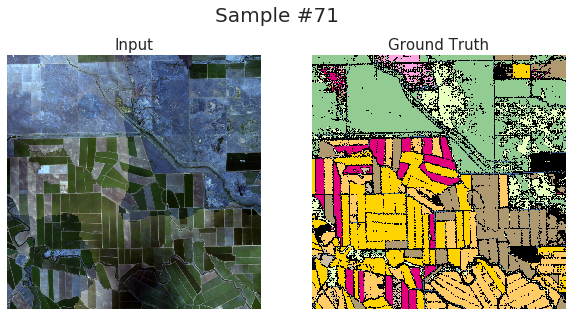

In [9]:
i = 3
sample_id = sample_idxes[i]
# sample_id = sample_filepaths[sample_idxes[i]].split('/')[-1].split('_maxNDVItimestep_')[0]
print(sample_id)

if not os.path.exists(SAVE_DIR+"/sample_{}".format(sample_id)):
    os.makedirs(SAVE_DIR+"/sample_{}".format(sample_id))

sample = np.load(sample_filepaths[sample_idxes[i]])    
print(sample_idxes[i], sample.shape)

image, gt_mask = sample[...,:3].astype('uint8'), sample[...,-1] ## because SAM expects uint8 inputs
print(image.shape, gt_mask.shape)

utils.plot_sample(img=image, mask=gt_mask, titlestr=f"Sample #{sample_id}")

### Convert multi-class mask to a set of binary masks

The input to `SamPredictor` is (`point_coords`, `point_labels`) where,

- `point_coords` (np.ndarray or None): A Nx2 array of point prompts to the model. Each point is in (X,Y) in pixels.

- `point_labels` (np.ndarray or None): A length N array of labels for the point prompts. 1 indicates a foreground point and 0 indicates a background point.

#### Steps to get this from CDL

1. Convert CDL to multiple binary masks by one-hot encoding the CDL.
2. For each class, sample coords of some 1s from the binary class mask. 

In [10]:
cdl_binary_masks = np.array([np.where(gt_mask==i, 1, 0) for i in np.unique(gt_mask)])
crop_ids = list(np.unique(gt_mask))
print(cdl_binary_masks.shape)
print(crop_ids)

print()

counts_dict = {}
for i, crop_id in enumerate(crop_ids):
    counts_dict[crop_id] = np.count_nonzero(cdl_binary_masks[i,:,:])
counts_dict = dict(sorted(counts_dict.items(), key=lambda item: item[1], reverse=True))
counts_dict_perc = {k: np.round(v/np.sum(list(counts_dict.values())),3) for k, v in counts_dict.items()}
print(counts_dict)
print(counts_dict_perc)

print()

crop_ids__reverse_sorted_by_pixel_count = [k for k,v in counts_dict_perc.items() if v>0.05]
print(crop_ids__reverse_sorted_by_pixel_count)
valid_crop_ids__reverse_sorted_by_pixel_count = [crop_id for crop_id in crop_ids__reverse_sorted_by_pixel_count if crop_id not in [100,0]]

(17, 1098, 1098)
[0, 1, 5, 8, 9, 13, 15, 18, 19, 20, 21, 22, 24, 25, 26, 27, 100]

{100: 305825, 24: 265305, 1: 186040, 9: 144581, 19: 130066, 25: 69254, 5: 65264, 27: 14886, 20: 11266, 22: 11108, 0: 1129, 26: 521, 13: 297, 21: 40, 18: 8, 8: 7, 15: 7}
{100: 0.254, 24: 0.22, 1: 0.154, 9: 0.12, 19: 0.108, 25: 0.057, 5: 0.054, 27: 0.012, 20: 0.009, 22: 0.009, 0: 0.001, 26: 0.0, 13: 0.0, 21: 0.0, 18: 0.0, 8: 0.0, 15: 0.0}

[100, 24, 1, 9, 19, 25, 5]


### Get Predictions

Full explanation of all options available in `SamPredictor` can be found here - 
https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/predictor.py

In [13]:
predictor = SamPredictor(sam)
predictor.set_image(image)

CDL Label: 24, pred_IoU=0.6075476408004761
(1098, 1098, 3) (1098, 1098) (1098, 1098) (1098, 1098)


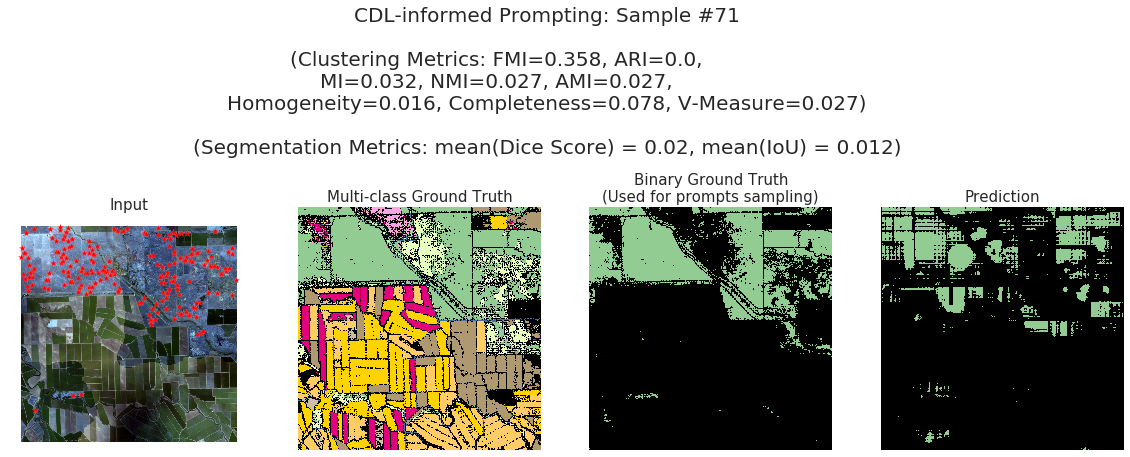

CDL Label: 1, pred_IoU=0.5737040042877197
(1098, 1098, 3) (1098, 1098) (1098, 1098) (1098, 1098)


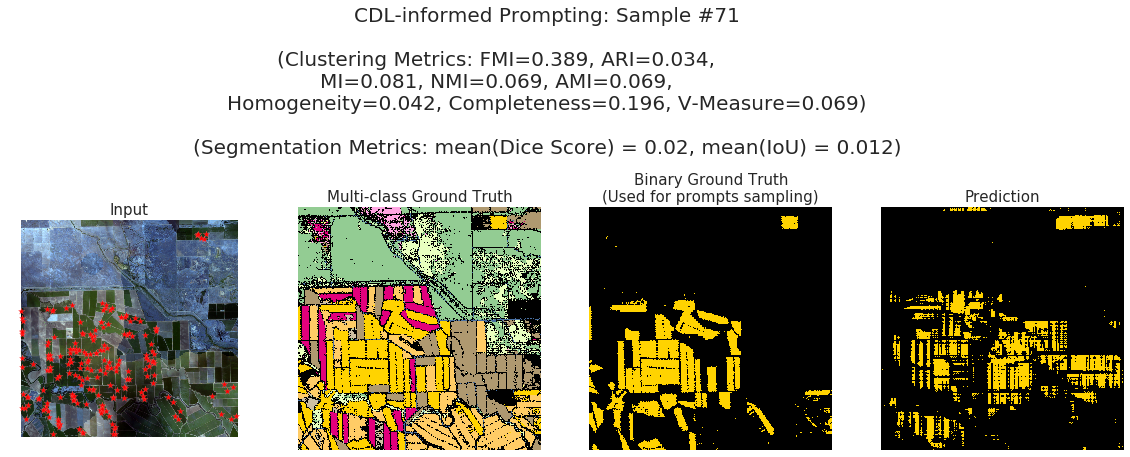

CDL Label: 9, pred_IoU=0.5745124816894531
(1098, 1098, 3) (1098, 1098) (1098, 1098) (1098, 1098)


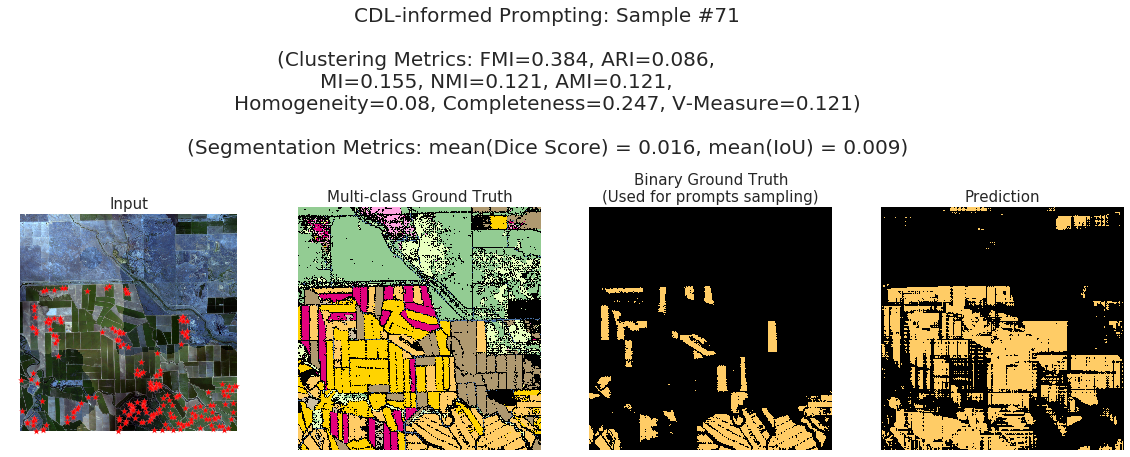

CDL Label: 19, pred_IoU=0.5690417885780334
(1098, 1098, 3) (1098, 1098) (1098, 1098) (1098, 1098)


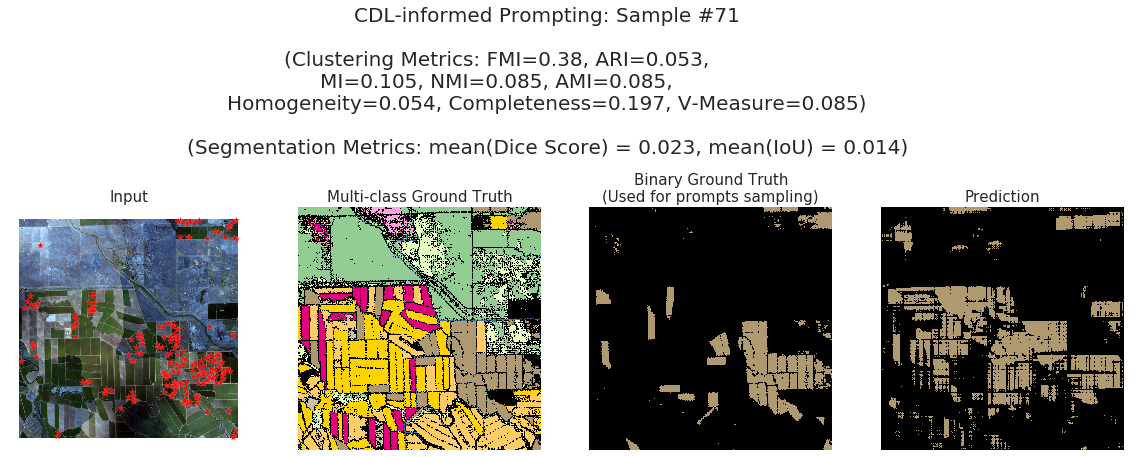

CDL Label: 25, pred_IoU=0.5857583284378052
(1098, 1098, 3) (1098, 1098) (1098, 1098) (1098, 1098)


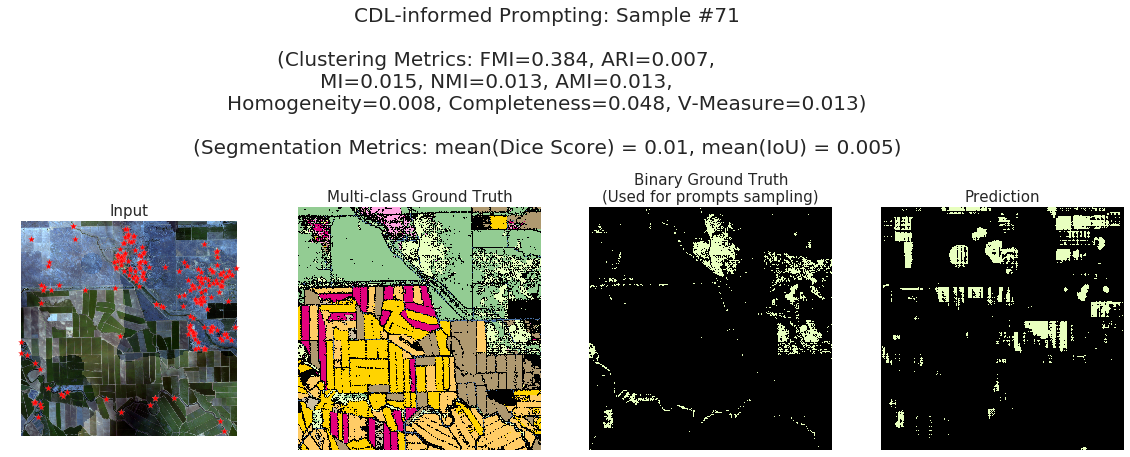

CDL Label: 5, pred_IoU=0.6035082936286926
(1098, 1098, 3) (1098, 1098) (1098, 1098) (1098, 1098)


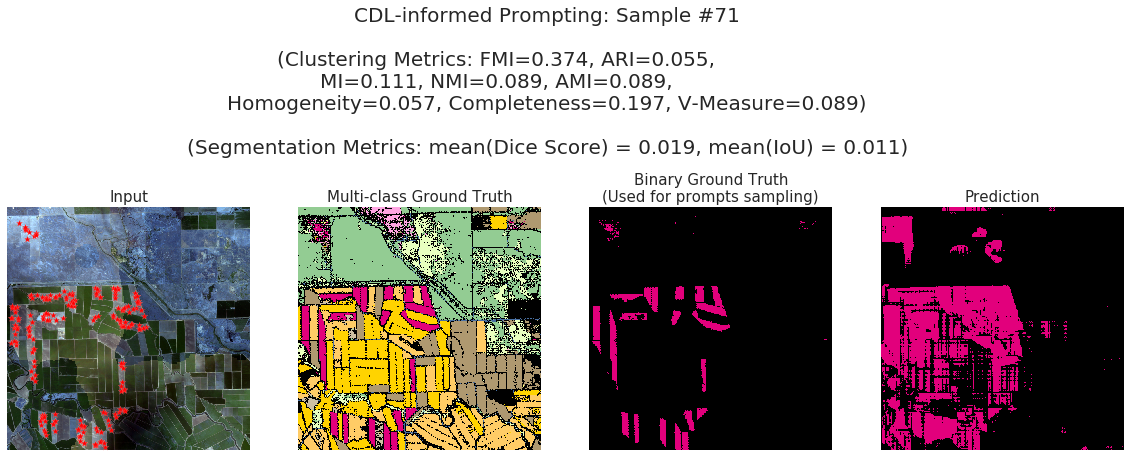

In [14]:
# nth_largest = 3
# cdl_label = crop_ids__reverse_sorted_by_pixel_count[nth_largest]
# print(cdl_label)
pos_prompts_only  = True
pred_bin_masks = []
pred_bin_masks_iou = []
for cdl_label in valid_crop_ids__reverse_sorted_by_pixel_count:
    
    pos_bin_mask = cdl_binary_masks[crop_ids.index(cdl_label),:,:]
    neg_bin_mask = cdl_binary_masks[[crop_ids.index(100), crop_ids.index(0)],:,:] ## Or should this be all other classes?
    # print(f"pos_bin_mask: {pos_bin_mask.shape}, {np.unique(pos_bin_mask)}")
    # print(f"neg_bin_mask: {neg_bin_mask.shape}, {np.unique(neg_bin_mask)}")

    pos_prompt_coords = np.argwhere(pos_bin_mask==1)[:,[1,0]]
    pos_prompt_labels = np.ones(len(pos_prompt_coords)).astype(int)    
    # print(pos_prompt_coords.shape, pos_prompt_labels.shape)
    # print(pos_prompt_coords[:2], pos_prompt_labels[:2])

    neg_prompt_coords = np.argwhere(neg_bin_mask==1)[:,[1,0]]
    neg_prompt_labels = np.zeros(len(neg_prompt_coords)).astype(int)
    # print(neg_prompt_coords.shape, neg_prompt_labels.shape)
    # print(neg_prompt_coords[:2], neg_prompt_labels[:2])

    num_prompts = 200
    pos_prompt_coords_sample_idxes = np.random.choice(range(len(pos_prompt_labels)), num_prompts)
    neg_prompt_coords_sample_idxes = np.random.choice(range(len(neg_prompt_labels)), num_prompts)

    if pos_prompts_only:
        input_points = pos_prompt_coords[pos_prompt_coords_sample_idxes]
        input_labels = pos_prompt_labels[pos_prompt_coords_sample_idxes]
    else:
        input_points = np.concatenate([pos_prompt_coords[pos_prompt_coords_sample_idxes], 
                                    neg_prompt_coords[neg_prompt_coords_sample_idxes]])
        input_labels = np.concatenate([pos_prompt_labels[pos_prompt_coords_sample_idxes], 
                                    neg_prompt_labels[neg_prompt_coords_sample_idxes]])

    # print(f"Input Prompts - points: {input_points.shape}, labels: {input_labels.shape}")

    pos_bin_mask_cdl = pos_bin_mask * cdl_label
    neg_bin_mask_cdl = neg_bin_mask * 100
    # print(pos_bin_mask_cdl.shape, np.unique(pos_bin_mask_cdl))
    # print(neg_bin_mask_cdl.shape, np.unique(neg_bin_mask_cdl))

    masks, iou_predictions, low_res_masks = predictor.predict(
                                                                point_coords=input_points,
                                                                point_labels=input_labels,
                                                                multimask_output=False,    
                                                            )
    pred_bin_mask_cdl = masks[0]*cdl_label
    # print(masks.shape, pred_bin_mask_cdl.shape)
    # print(iou_predictions)
    # print(low_res_masks.shape)
    pred_bin_masks.append(pred_bin_mask_cdl)
    pred_bin_masks_iou.append(iou_predictions[0])

    print(f"CDL Label: {cdl_label}, pred_IoU={iou_predictions[0]}")

    clust_score, mean_dice_coeff, mean_iou = utils.calc_metrics(gt_mask=gt_mask, 
                                                                pred_mask=pred_bin_mask_cdl, 
                                                                clust_only=False)
    
    titlestr=f"CDL-informed Prompting: Sample #{sample_id}\n"
    titlestr += f"\n(Clustering Metrics: FMI={clust_score['FMI']}, ARI={clust_score['ARI']},\
                \nMI={clust_score['MI']}, NMI={clust_score['NMI']}, AMI={clust_score['AMI']},\
                \nHomogeneity={clust_score['Homogeneity']}, Completeness={clust_score['Completeness']}, V-Measure={clust_score['V-Measure']})"
    titlestr += f"\n\n(Segmentation Metrics: mean(Dice Score) = {np.round(mean_dice_coeff, 3)}, mean(IoU) = {np.round(mean_iou, 3)})"
    
    utils.plot_bin_prediction(
                                input=image,
                                gt_mask=gt_mask, 
                                pred_mask=pred_bin_mask_cdl,
                                gt_bin_mask=pos_bin_mask_cdl,
                                input_points=input_points,
                                input_labels=input_labels,
                                titlestr=titlestr,
                                show=True, 
                                save=False, SAVE_PATH=SAVE_DIR+f"/sample_{sample_id}/cdl({cdl_label})_CDL-informed_prompting.png"
                            )
    

#### Combine binary masks into a multi-class mask

In [15]:
print(np.array(pred_bin_masks).shape)
print(pred_bin_masks_iou)
print(np.argsort(pred_bin_masks_iou))

(6, 1098, 1098)
[0.60754764, 0.573704, 0.5745125, 0.5690418, 0.5857583, 0.6035083]
[3 1 2 4 5 0]


Combining binary masks into a multi-class mask...
(1098, 1098) [ 0  1  5 24]
(1098, 1098) [  0   1   5   8   9  13  15  18  19  20  21  22  24  25  26  27 100]
DONE!
Plotting...


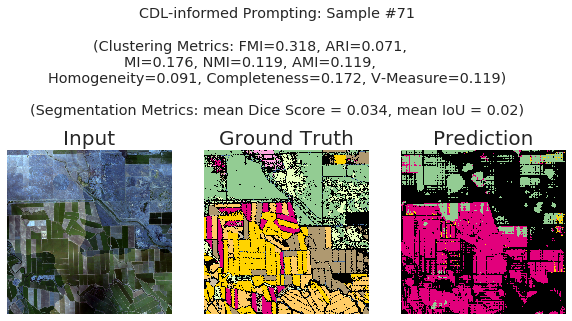

In [16]:
print("Combining binary masks into a multi-class mask...")
pred_mask = np.zeros((image.shape[0], image.shape[1]))
for idx in np.argsort(pred_bin_masks_iou):
    cdl_val = pred_bin_masks[idx].max()
    pred_mask += pred_bin_masks[idx].astype(int)
    pred_mask = np.where(pred_mask > cdl_val, cdl_val, pred_mask)
pred_mask = pred_mask.astype(int)
print(pred_mask.shape, np.unique(pred_mask))
print(gt_mask.shape, np.unique(gt_mask))
print("DONE!")

clust_score, mean_dice_coeff, mean_iou = utils.calc_metrics(gt_mask=gt_mask, pred_mask=pred_mask, clust_only=False) 

print("Plotting...")
titlestr=f"CDL-informed Prompting: Sample #{sample_id}\n"
titlestr += f"\n(Clustering Metrics: FMI={clust_score['FMI']}, ARI={clust_score['ARI']},\
            \nMI={clust_score['MI']}, NMI={clust_score['NMI']}, AMI={clust_score['AMI']},\
            \nHomogeneity={clust_score['Homogeneity']}, Completeness={clust_score['Completeness']}, V-Measure={clust_score['V-Measure']})"
titlestr += f"\n\n(Segmentation Metrics: mean Dice Score = {np.round(mean_dice_coeff, 3)}, mean IoU = {np.round(mean_iou, 3)})"

utils.plot_prediction(input=image,
                        gt_mask=gt_mask,
                        pred_mask=pred_mask,
                        colormap_pred_mask=True,
                        # input_points=input_points,
                        # input_labels=input_labels,
                        titlestr=titlestr,
                        show=True, 
                        save=False, SAVE_PATH=SAVE_DIR+f"/sample_{sample_id}_CDL-informed_prompting.png"
                    )

The predictions are bad and too noisy. Perhaps I could use the AMG masks to clean these ones?

#### SAM Automatic Mask Generator: Uniformly distrubted Prompts

Full explanation of all options available in `SamAutomaticMaskGenerator` can be found here - https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

  0%|          | 0/1 [00:00<?, ?it/s]

1 1
Defining mask generator...
DONE!
Generating masks...
For sample 71, SAM generated 328 boolean masks!
Max cluster id = 255
num_labels_in_pred_mask = 239
DONE!
Evaluating clustering consensus...
DONE!
Plotting...


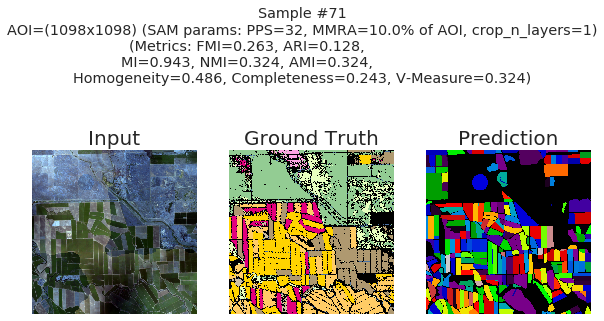

DONE!


In [17]:
from utils import plot_prediction, eval_clustering

img_w, img_h = aoi_size, aoi_size
min_mask_region_fracs_vals = [1e-1]
# min_mask_area_vals = [int(min_mask_area_frac*img_w*img_h) for min_mask_area_frac in min_mask_region_frac_vals]
pps_vals = [32]
crop_n_layers_vals = [1]
crop_n_points_downscale_factor = 1

for pps in pps_vals:
    for min_mask_area_frac in tqdm(min_mask_region_fracs_vals, leave=False):
        min_mask_area = int(min_mask_area_frac*img_w*img_h)
        min_mask_area_perc = min_mask_area_frac*100
        for crop_n_layers in crop_n_layers_vals:
            # for crop_n_points_downscale_factor in crop_n_points_downscale_factor_vals:
            # try:
            print(crop_n_layers, crop_n_points_downscale_factor)
            
            titlestr = "AOI=({}x{}) (SAM params: PPS={}, MMRA={}% of AOI, crop_n_layers={})"\
                        .format(img_w, img_h, pps, min_mask_area_perc, crop_n_layers)
            # print(titlestr)

            print("Defining mask generator...")
            mask_generator = SamAutomaticMaskGenerator(model=sam,
                                                        points_per_side=pps,
                                                        pred_iou_thresh=0.95,
                                                        stability_score_thresh=0.95,
                                                        # box_nms_thresh=0.0,
                                                        # crop_nms_thresh=0.0,
                                                        crop_n_layers=crop_n_layers,
                                                        crop_n_points_downscale_factor=crop_n_points_downscale_factor,
                                                        min_mask_region_area=min_mask_area,  # Requires open-cv to run post-processing
                                                    )
            print("DONE!")

            print("Generating masks...")
            masks = mask_generator.generate(image)
            # print(masks[0].keys())
            print("For sample {}, SAM generated {} boolean masks!".format(sample_id, len(masks)))
            ## Sort masks by stability score
            masks = sorted(masks, key=lambda d: d['stability_score']) 

            ## How many pixels got no mask?
            # pred_mask = np.logical_or.reduce(np.array([mask['segmentation'] for mask in masks]), axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Checking for any overlap in the masks
            # bin_masks = np.array([np.array(mask['segmentation']).astype(int) for mask in masks])
            # print(collections.Counter(bin_masks.flatten()))
            # pred_mask = np.sum(bin_masks, axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Transform N boolean overlapping masks into one numerically encoded mask
            pred_mask = np.zeros((image.shape[0], image.shape[1]))
            # pred_mask = masks[0]['segmentation'].astype(int)
            for i in range(len(masks)):
                val = i+1
                pred_mask += masks[i]['segmentation'].astype(int) * val
                pred_mask = np.where(pred_mask > val, val, pred_mask)
            pred_mask = pred_mask.astype('uint8')
            print(f"Max cluster id = {pred_mask.flatten().max()}")
            print(f"num_labels_in_pred_mask = {len(np.unique(pred_mask))}")
            print("DONE!")

            print("Evaluating clustering consensus...")
            clust_score = eval_clustering(labels_true=gt_mask.flatten(), labels_pred=pred_mask.flatten())
            print("DONE!")
            
            print("Plotting...")
            titlestr += f"\n(Metrics: FMI={clust_score['FMI']}, ARI={clust_score['ARI']},\
                        \nMI={clust_score['MI']}, NMI={clust_score['NMI']}, AMI={clust_score['AMI']},\
                        \nHomogeneity={clust_score['Homogeneity']}, Completeness={clust_score['Completeness']}, V-Measure={clust_score['V-Measure']})"
            titlestr = f"Sample #{sample_id}\n"+titlestr
            plot_prediction(input=image, gt_mask=gt_mask, pred_mask=pred_mask, 
                            titlestr=titlestr,
                            show=True, save=False)
            # plot_prediction(input=image, gt_mask=gt_mask, pred_mask=pred_mask, 
            #                 titlestr="",
            #                 show=True, save=False)
            print("DONE!")
            # except Exception as e:
            #     print("Error encountered! Continuing...")
            #     print(e)
            #     continue


In [12]:
# import json_tricks
# masks_dict = {}
# masks_dict[str(sample_id)] = masks
# SAVE_DIR = "/home/rgura001/segment-anything/sam4crops/results/nbk"
# with open(SAVE_DIR+"/predicted_masks.json", "w") as fp:
#     json_tricks.dump(masks_dict, fp)

# masks_dict_loaded = json_tricks.load(open(SAVE_DIR+"/predicted_masks.json", "r"))
# print(dict(masks_dict_loaded).keys())
# print(dict(masks_dict_loaded[str(sample_id)][0]).keys())

In [1]:
# pprint(list(mask_generator.__dict__.keys()))